## Libraries

In [1]:
import cooler

from cooltools import insulation
import cooltools

import numpy as np
import pandas as pd
import bbi
import scipy
import bioframe
from scipy.ndimage import gaussian_filter1d

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

from itertools import combinations
import tqdm

import tad_common
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

/home/carlos/miniconda3/envs/gnn/lib/python3.11/site-packages/cooltools/lib/numutils.py:651: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit  # (nopython=True)
/home/carlos/miniconda3/envs/gnn/lib/python3.11/site-packages/cooltools/lib/numutils.py:726: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit  # (nopython=True)


## Get TADs

In [2]:
NPROC = 8
resolution = 10000
windows = [50*resolution]

sample_names = {'Control' : 0, '12min': 12, '30min': 30, '60min': 60}
clr_ = [cooler.Cooler(f"/home/carlos/Desktop/manuscripts/notebooks/matrices/t{sample}_q30.mcool::resolutions/{resolution}") for sample in sample_names.values()]

In [ ]:
# get boundaries
insulation_table_ = [
    insulation(clr, 
    windows, 
    verbose=False, 
    nproc = NPROC) 
    for clr in clr_
    ]
for sample_name, ins_df in zip(sample_names.keys(), insulation_table_):
    ins_df.to_csv(f"insulation_df_{sample_name}_{windows[0]}.tsv", sep="\t", index=False)
import tad_common
accepted_range = 1
only_strong_base = True
combs_df = tad_common.boundary_switch(
    ins_df_list = insulation_table_, 
    sample_names = list(sample_names.keys()),
    window = windows[0], 
    only_strong_base = only_strong_base, 
    accepted_range = accepted_range)

In [11]:
# run if cached already
insulation_table_ = [pd.read_csv(f"insulation_df_{sample_name}_{windows[0]}.tsv", sep="\t") for sample_name in sample_names.keys()]
import tad_common
accepted_range = 1
only_strong_base = True
combs_df = tad_common.boundary_switch(
    ins_df_list = insulation_table_, 
    sample_names = list(sample_names.keys()),
    window = windows[0], 
    only_strong_base = only_strong_base, 
    accepted_range = accepted_range)

Processing 30min and Control
Sample1 index: 2, Sample2 index: 0
Total #bins to process of 30min: 3694
Processing Control and 12min
Sample1 index: 0, Sample2 index: 1
Total #bins to process of Control: 3721
Processing Control and 60min
Sample1 index: 0, Sample2 index: 3
Total #bins to process of Control: 3721
Processing 12min and Control
Sample1 index: 1, Sample2 index: 0
Total #bins to process of 12min: 3718
Processing 60min and 30min
Sample1 index: 3, Sample2 index: 2
Total #bins to process of 60min: 3653
Processing 60min and 12min
Sample1 index: 3, Sample2 index: 1
Total #bins to process of 60min: 3653
Processing 30min and 60min
Sample1 index: 2, Sample2 index: 3
Total #bins to process of 30min: 3694
Processing 60min and Control
Sample1 index: 3, Sample2 index: 0
Total #bins to process of 60min: 3653
Processing 12min and 60min
Sample1 index: 1, Sample2 index: 3
Total #bins to process of 12min: 3718
Processing 30min and 12min
Sample1 index: 2, Sample2 index: 1
Total #bins to process o

In [4]:
combs_df = pd.read_csv("boundary_switch_1_True.tsv", sep="\t") # Load precomputed if available

In [5]:
combs_df.loc[combs_df['case'] == "Shifted", 'case'] = "Preserved"
combs_df = combs_df[(combs_df['sample1'] == "Control") & (combs_df['sample2'] == "12min")]
combs_df = combs_df[combs_df['case'] == "Preserved"]
combs_df = combs_df.reset_index(drop=True)

In [6]:
# prep expected for background in viz
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)
hg38_arms = hg38_arms.set_index("chrom").loc[clr_[0].chromnames].reset_index()
hg38_arms = bioframe.make_viewframe(hg38_arms)

expected_ = [cooltools.expected_cis(
        clr=clr,
        view_df=hg38_arms,
        smooth=False,
        aggregate_smoothed=False,
        nproc=NPROC,
        clr_weight_name='weight') for clr in clr_]

In [7]:
# get tads
def make_tads(insul_df, maxlen=1_500_000, minlen=100_000):
        tads = (
        insul_df.groupby("chrom")
        .apply(
            lambda x: pd.concat(
                [x[:-1].reset_index(drop=True), x[1:].reset_index(drop=True)],
                axis=1,
                ignore_index=True,
            )
        )
        .reset_index(drop=True)
        )
        tads.columns = [["chrom1", "start1", "end1", "chrom2", "start2", "end2"]]
        tads.columns = tads.columns.get_level_values(0)

        tads = tads[
            ((tads["start2"] - tads["start1"]) <= maxlen) & ((tads["start2"] - tads["start1"]) >= minlen)
        ].reset_index(drop=True)

        tads["start"] = (tads["start1"] + tads["end1"]) // 2
        tads["end"] = (tads["start2"] + tads["end2"]) // 2
        tads = tads[["chrom1", "start", "end"]]
        tads.columns = ['chrom', 'start', 'end']
        return tads

from coolpuppy import coolpup
from coolpuppy.lib.numutils import get_domain_score

def add_domain_score(snippet):
    snippet['domain_score'] = f"{get_domain_score(snippet['data'])}_{snippet['chrom1']}_{snippet['start1']}_{snippet['end1']}_{snippet['chrom2']}_{snippet['start2']}_{snippet['end2']}"
    return snippet

from more_itertools import collapse
def accumulate_values(dict1, dict2, key):
    assert key in dict2, f"{key} not in dict2"
    if key in dict1:
        dict1[key] = list(collapse([dict1[key], dict2[key]]))
    else:
        dict1[key] = [dict2[key]]
    return dict1

def extra_sum_func(dict1, dict2):
    return accumulate_values(dict1, dict2, 'domain_score')

In [8]:
boundary_idx = combs_df.idx1.values

In [12]:
insul_df = insulation_table_[0].iloc[boundary_idx].reset_index(drop=True)
tads_df = make_tads(insul_df[insul_df['is_boundary_500000']][['chrom', 'start', 'end']])
# blacklist = bioframe.read_table('/cta/users/vkaya/gnn/matrix/hg38-blacklist.v2.bed')
# blacklist.columns = ['chrom', 'start', 'end', 'reason']
# tads_df = bioframe.ops.subtract(tads_df, blacklist)
tads_df = tads_df.loc[tads_df['end'] - tads_df['start'] >= 100_000].reset_index(drop=True)

## Domain Scores

In [13]:
cc = coolpup.CoordCreator(tads_df, resolution=10000, features_format='bed', local=True, rescale_flank=1)

hg38_arms_filtered_idx = hg38_arms.loc[hg38_arms['name'].isin(bioframe.overlap(hg38_arms, tads_df, how='inner').name.unique())].index

hg38_arms_filtered = hg38_arms.loc[hg38_arms_filtered_idx].reset_index(drop=True)

pu = coolpup.PileUpper(clr_[1], cc, expected=expected_[1], view_df=hg38_arms_filtered, ignore_diags=0, rescale_size=99, rescale=True, nproc = NPROC)
pup = pu.pileupsWithControl(postprocess_func=add_domain_score,
                            extra_sum_funcs={
                                'domain_score': extra_sum_func}
                            )

INFO:coolpuppy:Rescaling with rescale_flank = 1 to 99x99 pixels
INFO:coolpuppy:('chr4_p', 'chr4_p'): 41
INFO:coolpuppy:('chr3_p', 'chr3_p'): 86
INFO:coolpuppy:('chr5_p', 'chr5_p'): 28
INFO:coolpuppy:('chr2_p', 'chr2_p'): 95
INFO:coolpuppy:('chr8_p', 'chr8_p'): 47
INFO:coolpuppy:('chr1_p', 'chr1_p'): 142
INFO:coolpuppy:('chr6_p', 'chr6_p'): 78
INFO:coolpuppy:('chr7_p', 'chr7_p'): 61
INFO:coolpuppy:('chr4_q', 'chr4_q'): 112
INFO:coolpuppy:('chr3_q', 'chr3_q'): 93
INFO:coolpuppy:('chr6_q', 'chr6_q'): 100
INFO:coolpuppy:('chr8_q', 'chr8_q'): 93
INFO:coolpuppy:('chr1_q', 'chr1_q'): 121
INFO:coolpuppy:('chr9_p', 'chr9_p'): 37
INFO:coolpuppy:('chr10_p', 'chr10_p'): 38
INFO:coolpuppy:('chr7_q', 'chr7_q'): 78
INFO:coolpuppy:('chr5_q', 'chr5_q'): 133
INFO:coolpuppy:('chr2_q', 'chr2_q'): 125
INFO:coolpuppy:('chr12_p', 'chr12_p'): 39
INFO:coolpuppy:('chr11_p', 'chr11_p'): 59
INFO:coolpuppy:('chr9_q', 'chr9_q'): 97
INFO:coolpuppy:('chr16_q', 'chr16_q'): 43
INFO:coolpuppy:('chr17_p', 'chr17_p'): 25


In [14]:
n_q = 4
q_labels = [f'Q{i}' for i in range(1, n_q+1)]

scores = [float(val.split('_')[0]) for val in pup['domain_score'][0] if val.split('_')[0] != 'nan']
df = pd.DataFrame([val.split('_')[1:4] for val in pup['domain_score'][0] if val.split('_')[0] != 'nan'])
df.columns = ['chrom', 'start', 'end']
quartiles = pd.qcut(scores, q=n_q, labels=q_labels)
df['quartiles'] = quartiles
df['scores'] = scores

df.chrom = df.chrom.astype('category')
df.start = df.start.astype('int64')
df.end = df.end.astype('int64')

tad_domains_strengths = df

## Plot APAs of quantiles

In [15]:
tad_domains_strengths.scores.min(), tad_domains_strengths.scores.max()

(0.2234298343864914, 3.1959938501510186)

In [16]:
pup_per_quant = {}
for quant in q_labels:
    curr_df = tad_domains_strengths.loc[tad_domains_strengths['quartiles'] == quant]
    cc = coolpup.CoordCreator(curr_df, resolution=10000, features_format='bed', local=True, rescale_flank=1)
    pu = coolpup.PileUpper(clr_[0], cc, expected=expected_[0], view_df=hg38_arms, ignore_diags=0, rescale_size=99, rescale=True)
    pup_per_quant[quant] = pu.pileupsWithControl()

INFO:coolpuppy:Rescaling with rescale_flank = 1 to 99x99 pixels
INFO:coolpuppy:('chr1_p', 'chr1_p'): 43
INFO:coolpuppy:('chr1_q', 'chr1_q'): 30
INFO:coolpuppy:('chr2_p', 'chr2_p'): 26
INFO:coolpuppy:('chr2_q', 'chr2_q'): 34
INFO:coolpuppy:('chr3_p', 'chr3_p'): 17
INFO:coolpuppy:('chr3_q', 'chr3_q'): 21
INFO:coolpuppy:('chr4_p', 'chr4_p'): 12
INFO:coolpuppy:('chr4_q', 'chr4_q'): 33
INFO:coolpuppy:('chr5_p', 'chr5_p'): 5
INFO:coolpuppy:('chr5_q', 'chr5_q'): 25
INFO:coolpuppy:('chr6_p', 'chr6_p'): 15
INFO:coolpuppy:('chr6_q', 'chr6_q'): 29
INFO:coolpuppy:('chr7_p', 'chr7_p'): 14
INFO:coolpuppy:('chr7_q', 'chr7_q'): 26
INFO:coolpuppy:('chr8_p', 'chr8_p'): 16
INFO:coolpuppy:('chr8_q', 'chr8_q'): 19
INFO:coolpuppy:('chr9_p', 'chr9_p'): 11
INFO:coolpuppy:('chr9_q', 'chr9_q'): 18
INFO:coolpuppy:('chr10_p', 'chr10_p'): 8
INFO:coolpuppy:('chr10_q', 'chr10_q'): 30
INFO:coolpuppy:('chr11_p', 'chr11_p'): 17
INFO:coolpuppy:('chr11_q', 'chr11_q'): 24
INFO:coolpuppy:('chr12_p', 'chr12_p'): 9
INFO:cool

Q1
Q2
Q3
Q4


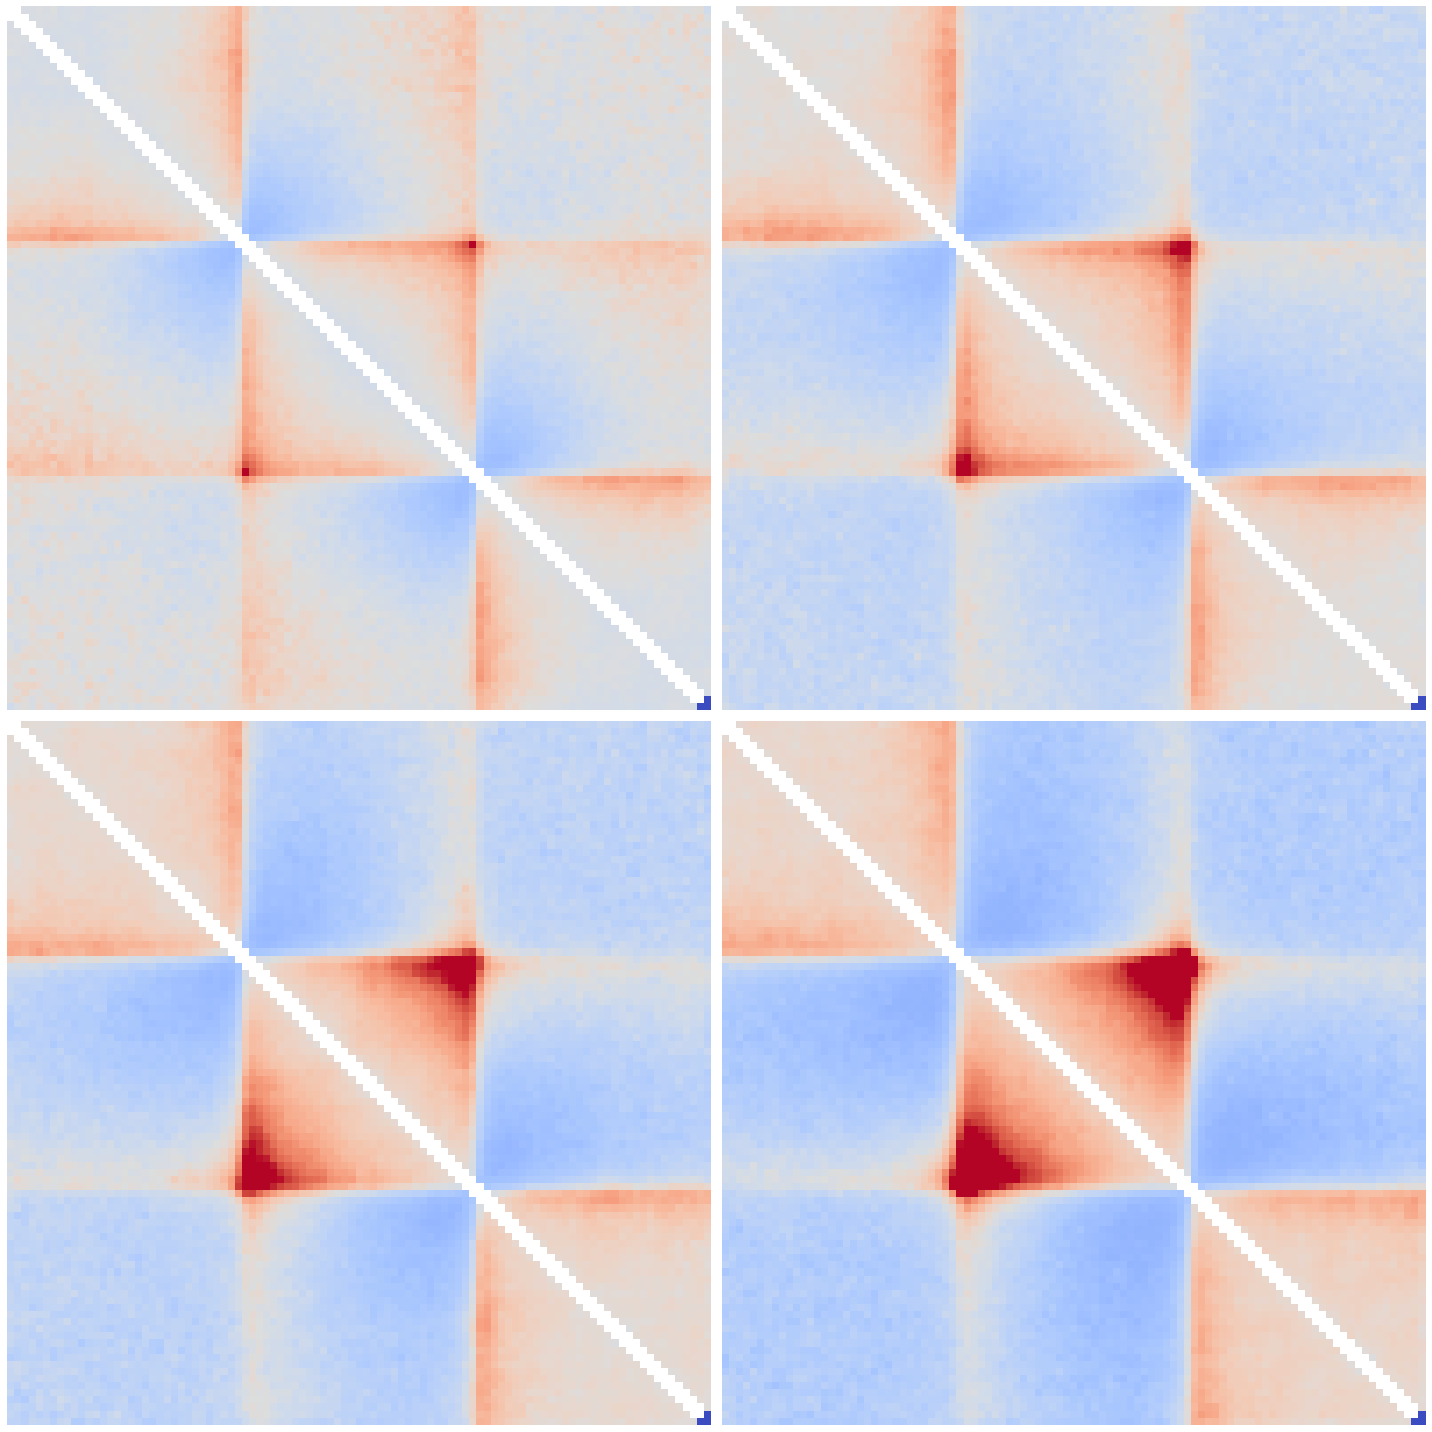

In [17]:
fig, ax = plt.subplots(figsize=(20, 20), nrows=2, ncols=2, sharex=True, sharey=True)
for quant in q_labels:
    print(quant)
    pup_now = pup_per_quant[quant].copy()
    sns.heatmap(pup_now['data'][0], ax=ax.flatten()[q_labels.index(quant)], cmap='coolwarm', vmax=2, yticklabels=False, xticklabels=False, cbar=False)

fig.tight_layout()
fig.savefig('tads_pup_quantiles.png', dpi=300)
fig.savefig('tads_pup_quantiles.svg')

## TADs ~ size

In [18]:
import bbi
chrom_sizes = bioframe.fetch_chromsizes("hg38")[:23]
def get_mean_bw(bw, chrom_sizes):
    for chrom in chrom_sizes.index:
        start, end = 0, chrom_sizes.loc[chrom] // 10000 * 10000
        yield np.nanmean(bbi.fetch(bw, chrom, start, end, bins=chrom_sizes.loc[chrom] // 1000))

BWS = {
    'xr-64-over-sim': '/home/carlos/Desktop/manuscripts/notebooks/bws/XR_64_real_over_sim_res1000.bw',
    'xr-cpd-over-sim': '/home/carlos/Desktop/manuscripts/notebooks/bws/XR_CPD_real_over_sim_res1000.bw',
    'ds-64-over-sim': '/home/carlos/Desktop/manuscripts/notebooks/bws/DS_64_real_over_sim_res1000.bw',
    'ds-cpd-over-sim': '/home/carlos/Desktop/manuscripts/notebooks/bws/DS_CPD_real_over_sim_res1000.bw',
    'rep-eff-64': '/home/carlos/Desktop/manuscripts/notebooks/bws/XR_64_rep_eff_res1000.bw',
    'rep-eff-cpd': '/home/carlos/Desktop/manuscripts/notebooks/bws/XR_CPD_rep_eff_res1000.bw',
    }

MEANS_BW = {}
for k in BWS:
    curr_mean = np.mean(list(get_mean_bw(BWS[k], chrom_sizes)))
    print(f"{k}: {curr_mean}")
    MEANS_BW[k] = curr_mean

interval_size = 1000
bws_per_key = {}
for k in BWS.keys():
    per_chr = []
    for chrName in chrom_sizes.index:
        chrLen = chrom_sizes.loc[chrName]
        start, end = 0, chrLen // interval_size * interval_size
        n_bins = end // interval_size
        arr_chr = bbi.fetch(
            BWS[k],
            chrName,
            start,
            end,
            bins=n_bins,
        )
        
        per_chr.append(arr_chr / MEANS_BW[k])
    bws_per_key[k] = per_chr


xr-64-over-sim: 1.1196280573820672
xr-cpd-over-sim: 1.1868305407819189
ds-64-over-sim: 1.23405186005681
ds-cpd-over-sim: 1.2698717973554339
rep-eff-64: 1.482119054797605
rep-eff-cpd: 1.567885930820114


In [19]:
chrom_sizes = bioframe.fetch_chromsizes("hg38")[:23]

data_df = []
for k in BWS.keys():

    regions = {
        "len": [],
        "data": [],
        "data_type": k,
    }

    for i, row in tads_df.iterrows():
        chrom, start, end = row['chrom'], row['start'], row['end']
        chrom_idx = chrom_sizes.index.get_loc(chrom)
        curr_arr = bws_per_key[k][chrom_idx][start//interval_size:end//interval_size]
        total_intervals = (end - start) // interval_size
        tad_length = end - start
        
        if len(curr_arr) != total_intervals: # filter out regions that exceed the chromosome length
            continue
        if len(np.where(curr_arr == np.nan)[0]) >= len(curr_arr * 10 / 100):
            print("nan")
            continue
        tad_mean_val = np.nanmean(curr_arr)

        regions["len"].append(tad_length)
        regions["data"].append(tad_mean_val)

    tad_df = pd.DataFrame(regions)
    data_df.append(tad_df)

data_df = pd.concat(data_df)

/tmp/ipykernel_6725/344664099.py:24: RuntimeWarning: Mean of empty slice
  tad_mean_val = np.nanmean(curr_arr)


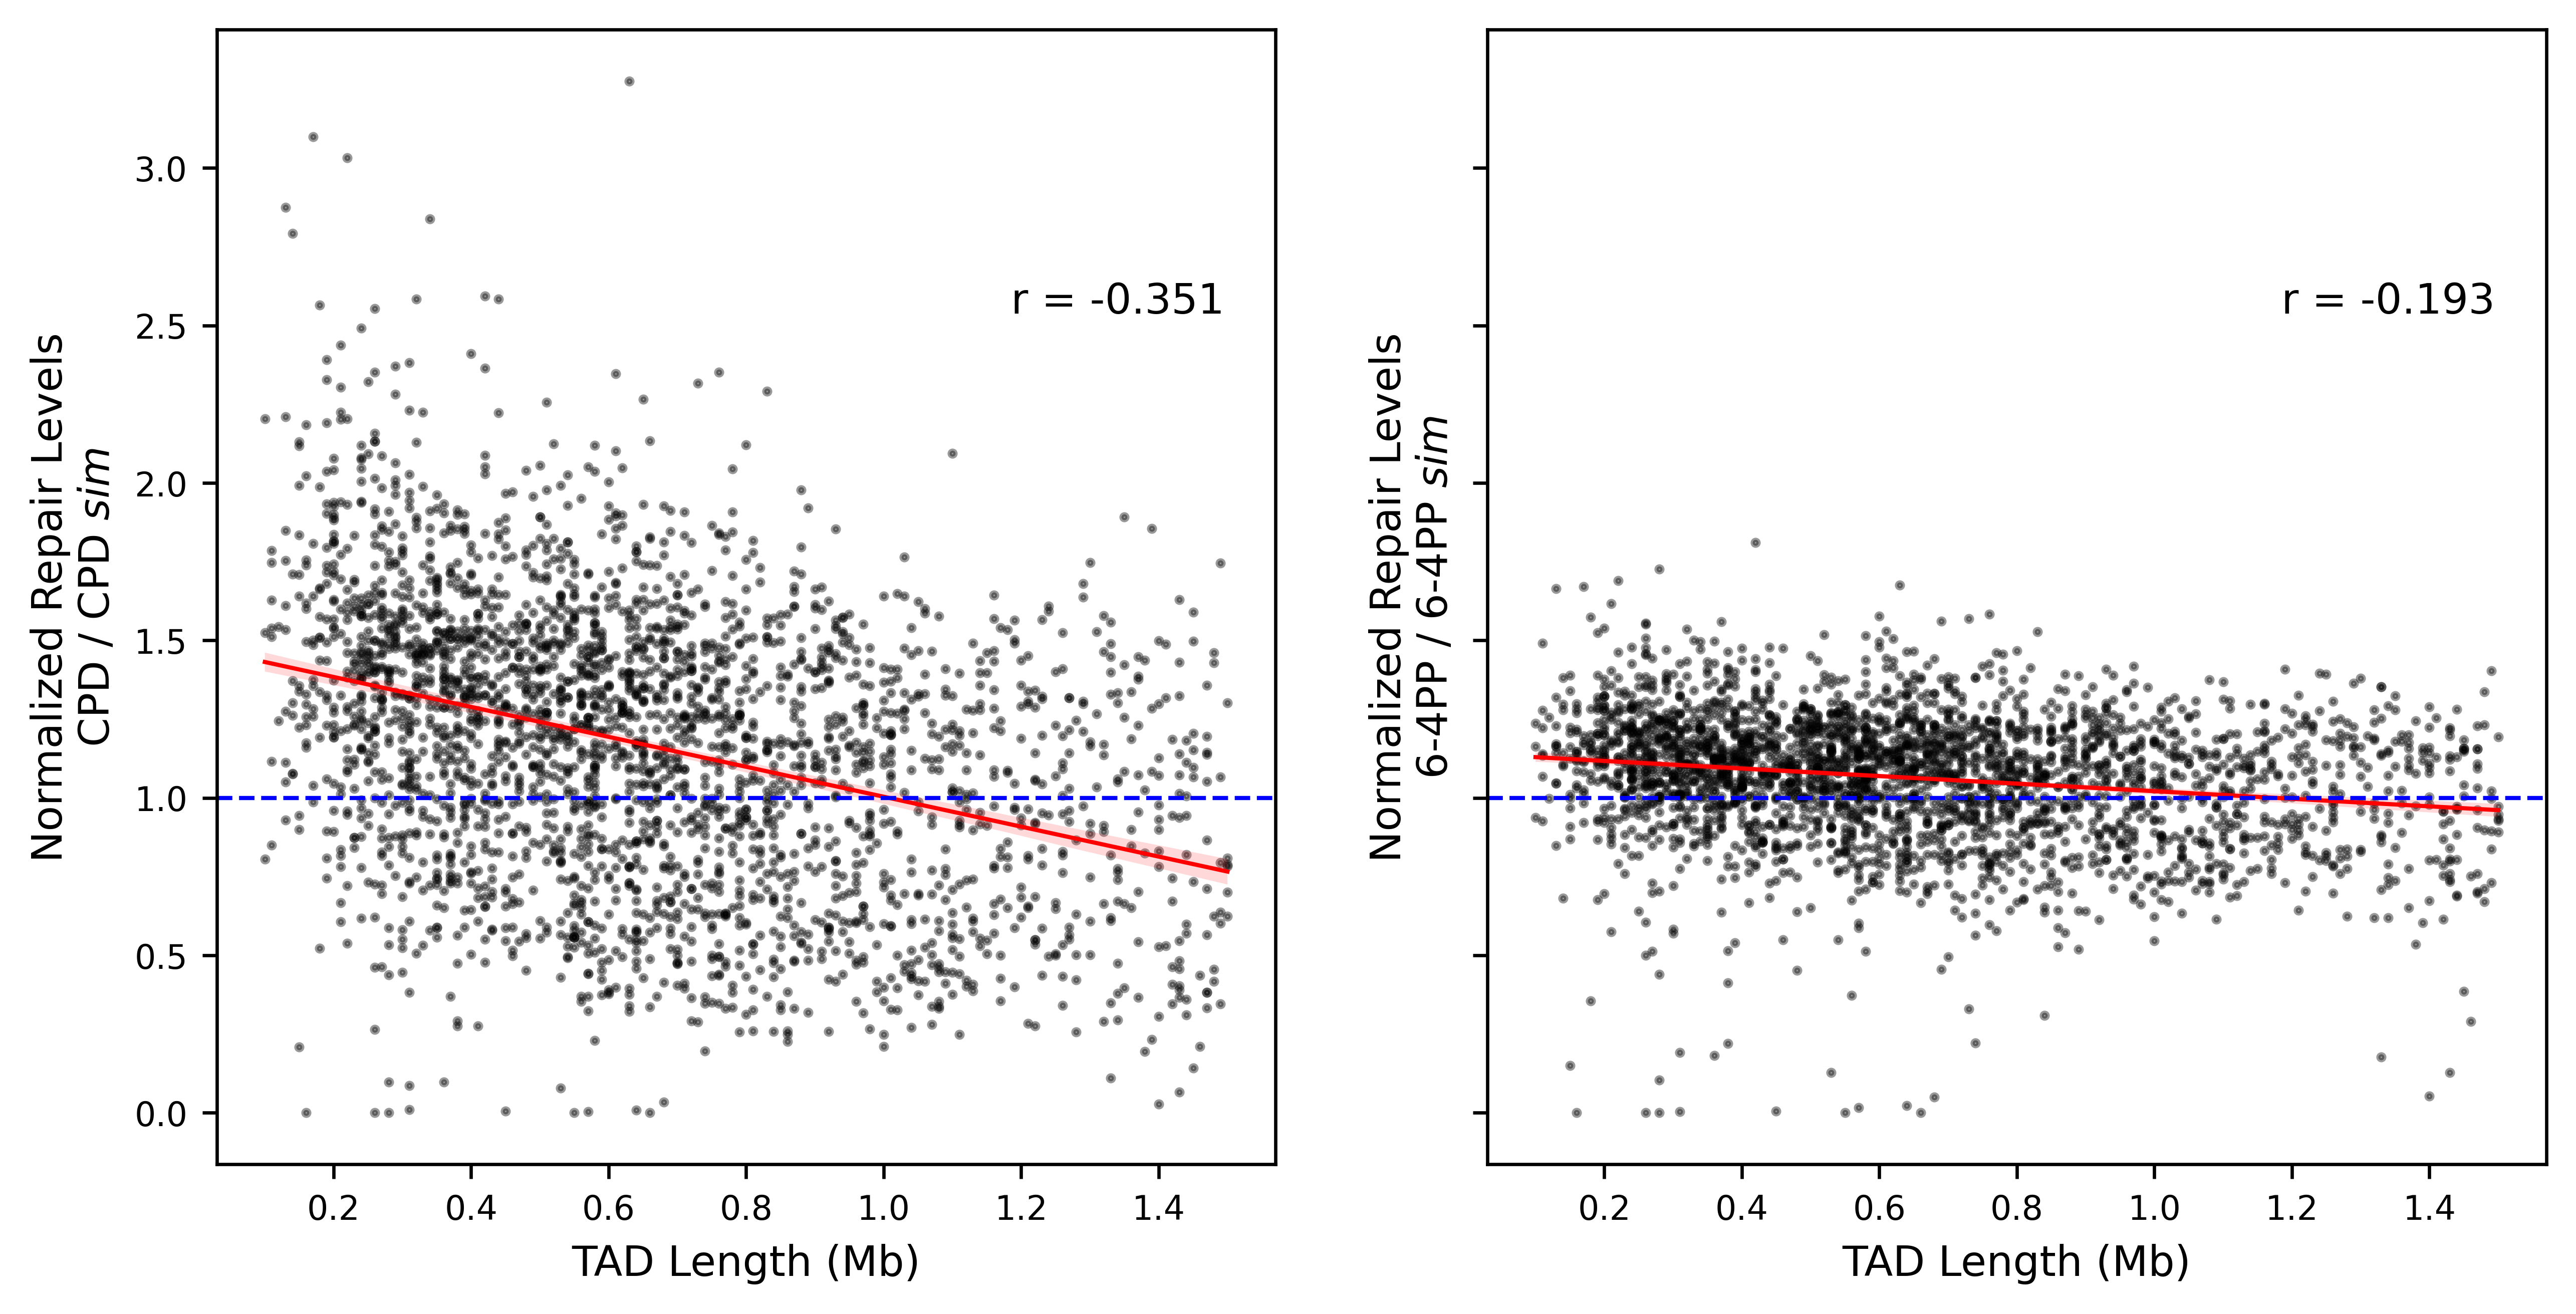

In [20]:
fig, ax_ = plt.subplots(
    ncols=2,
    sharey=True,
    sharex=True,
    dpi=600,
    figsize=(10, 5)
    )
# for i, rep in enumerate(['rep-eff-cpd', 'rep-eff-64']):
#     
for i, rep in enumerate(['xr-cpd-over-sim', 'xr-64-over-sim']):
    ax = ax_[i]
    df = data_df.copy()
    df = df.loc[df['data_type'] == rep]
    df['len'] = df['len'] / 1e6
    s = sns.regplot(
        data=df,
        x='len', y='data', 
        # change marker size to 1
        scatter_kws = {"color": "black", "alpha": 0.4, "s": 2},
        line_kws = {"color": "red", "lw": 1}, fit_reg=True, order=1,
        ax=ax)
    # s = sns.kdeplot(
    #     data=df,
    #     x='len', y='data', 
    #     ax=ax, cmap="mako", shade=True, fill=True, thresh=0.05, levels=20,)
    ax.ticklabel_format(style='plain', axis='both')
    r = scipy.stats.pearsonr(x=df.len, y=df.data)[0]
    ax.axhline(1, color='blue', linestyle='--', lw=1)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlabel('TAD Length (Mb)', fontsize=10)
    # create a string as "sim" as subscript notation for matplotlib
    sim_ss = '${sim}$'

    ylabel_ = f'Normalized Repair Levels\nCPD / CPD {sim_ss}' if "cpd" in rep else f'Normalized Repair Levels\n6-4PP / 6-4PP {sim_ss}'
    ax.set_ylabel(ylabel_, fontsize=10)
    ax.text(0.75, 0.75, f"r = {r:.3f}", transform=ax.transAxes, fontsize=10)
    # limit y axis
    #ax.set_ylim(0.5, 1.75)

fig.savefig('tad_length_vs_repair.svg', bbox_inches='tight')

In [21]:
def _bw_data(
    curr_DF, 
    flank, 
    n_bins_start, 
    n_bins_end, 
    n_bins_main, 
    mean_norm=True):

    start_data = {k: bbi.stackup(v,
                            curr_DF.chrom,
                            curr_DF.start - flank,
                            curr_DF.start,
                            bins=n_bins_start) 
                            for k, v in BWS.items()
                            }
    main_data = {k: bbi.stackup(v,
                            curr_DF.chrom,
                            curr_DF.start,
                            curr_DF.end,
                            bins=n_bins_main) 
                            for k, v in BWS.items()
                            }
    end_data = {k: bbi.stackup(v,
                            curr_DF.chrom,
                            curr_DF.end,
                            curr_DF.end + flank,
                            bins=n_bins_end)
                            for k, v in BWS.items()
                            }

    if mean_norm:
        for k in start_data:
            start_data[k] = start_data[k] / MEANS_BW[k]
        for k in main_data:
            main_data[k] = main_data[k] / MEANS_BW[k]
        for k in end_data:
            end_data[k] = end_data[k] / MEANS_BW[k]
    return start_data, main_data, end_data

In [22]:
start_data, main_data, end_data = _bw_data(tad_domains_strengths, 50_000, 25, 25, 50, mean_norm=False)

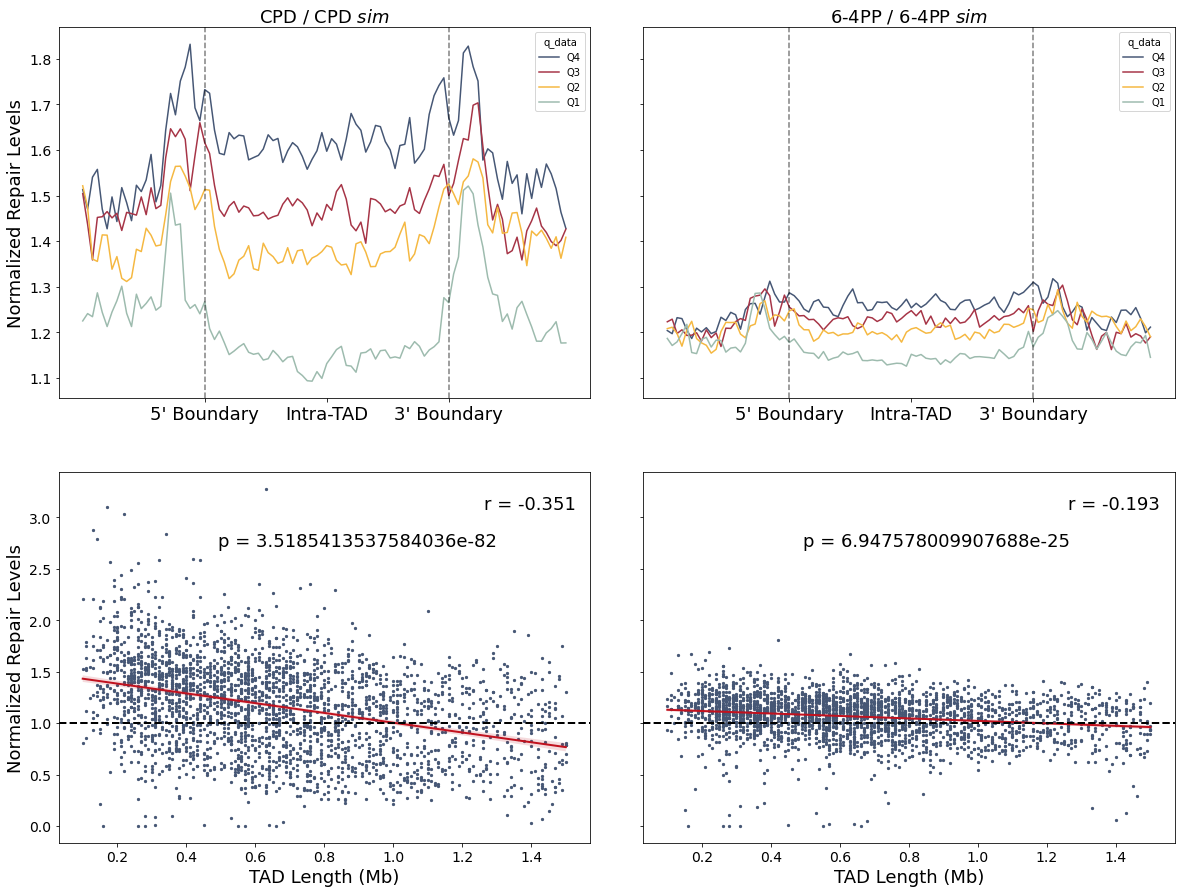

In [26]:

#data_names = ["xr-cpd-over-sim", "xr-64-over-sim", "ds-cpd-over-sim", "ds-64-over-sim", "rep-eff-cpd", "rep-eff-64"]
data_names = ["xr-cpd-over-sim", "xr-64-over-sim",]

fig, ax_ = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(20, 15),
    sharey="row",
    # make plots closer
    gridspec_kw=dict(wspace=0.1)
)
    
for idx, rep in enumerate(data_names):
    means_ = []
    for q in q_labels:
        # tad domain strengths at 12min, index 1
        idx_ = tad_domains_strengths.loc[tad_domains_strengths['quartiles'] == q].index
        main = np.nanmean(main_data[rep][idx_], axis=0)
        start = np.nanmean(start_data[rep][idx_], axis=0)
        end = np.nanmean(end_data[rep][idx_], axis=0)
        data = np.hstack([start, main, end])
        means_.append(gaussian_filter1d(data, sigma=.5))
        #means_.append(data)

    #ax = ax_[idx//2][idx%2]
    ax = ax_[0, idx]
    q_Df = {
        'data': np.hstack(means_),
        'q_data': np.hstack([[q] * len(arr) for q,arr  in zip(q_labels, means_)]),
        'n': np.hstack([np.arange(len(arr)) for arr in means_])
    }
    
    #cpal = sns.dark_palette("#465775", n_colors=n_q, reverse=False)

    q_Df = pd.DataFrame(q_Df)
    q_Df['q_data'] = q_Df['q_data'].astype('category')
    # reorder categories
    q_Df['q_data'] = q_Df['q_data'].cat.reorder_categories(q_labels[::-1])
    s = sns.lineplot(
        data = q_Df,
        x = "n",
        y = "data",
        hue = "q_data", ax = ax,
        #palette = list(cpal.as_hex())[::-1],
        palette = ["#465775", "#A63446", "#F5B841", "#9DBBAE"],)

    # add vertical lines at the start and end of the main domain
    ax.axvline(25, linestyle='--', color='black', alpha=.5)
    ax.axvline(75, linestyle='--', color='black', alpha=.5)
    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.set_xticks([25, 50, 75])
    ax.set_xticklabels(["5' Boundary", 'Intra-TAD', "3' Boundary"], fontsize=18)
    ax.set_xlabel('')

    sim_ss = '${sim}$'
    title = f'CPD / CPD {sim_ss}' if "cpd" in rep else f'6-4PP / 6-4PP {sim_ss}'
    # remove yaxis label
    ax.set_ylabel('Normalized Repair Levels', fontsize=18)

    # set title of plot
    ax.set_title(title, fontsize=18)

    # add horizontal line at 1
    #ax.axhline(1, linestyle='--', color='black', alpha=.5, lw=2)


    # remove legend
    #ax.get_legend().remove()

for i, rep in enumerate(data_names):
    ax = ax_[1, i]
    df = data_df.copy()
    df = df.loc[df['data_type'] == rep]
    df['len'] = df['len'] / 1e6
    #df = df.loc[df['data'] != 0]
    s = sns.regplot(
        data=df,
        x='len', y='data', 
        # change marker size to 1
        scatter_kws = {"color": "#465775", "alpha": 1, "s": 5},
        line_kws = {"color": "#C1121F", "lw": 2}, fit_reg=True, order=1,
        ax=ax)
    # s = sns.kdeplot(
    #     data=df,
    #     x='len', y='data', 
    #     ax=ax, cmap="mako", shade=True, fill=True, thresh=0.05, levels=20,)
    ax.ticklabel_format(style='plain', axis='both')
    stats_ = scipy.stats.pearsonr(x=df.len, y=df.data)
    r, p = stats_[0], stats_[1]
    ax.axhline(1, color='black', linestyle='--', lw=2)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel('TAD Length (Mb)', fontsize=18)
    ax.set_ylabel('Normalized Repair Levels', fontsize=18) if i == 0 else ax.set_ylabel('')
    # create a string as "sim" as subscript notation for matplotlib
    sim_ss = '${sim}$'
    #title = f'Normalized Repair Levels\nCPD / CPD {sim_ss}' if "cpd" in rep else f'Normalized Repair Levels\n6-4PP / 6-4PP {sim_ss}'
    # remove yaxis label

    ax.text(0.80, 0.90, f"r = {r:.3f}", transform=ax.transAxes, fontsize=18)
    ax.text(0.30, 0.80, f"p = {p}", transform=ax.transAxes, fontsize=18)
    # limit y axis
    #ax.set_ylim(0.5, 1.75)

fig.savefig('tads_domain_scores_sizes_repair_levels.svg', bbox_inches='tight')